In [412]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

# Import train & test data

In [322]:
b_train = pd.read_csv('data/b_train.csv')
b_train.describe()

,outcome,mean_time_diff,total_bids_count,total_auctions_count,mean_time_diff2
count,2013.000000,1.682000e+03,2013.000000,2013.000000,2005.000000
mean,0.051167,6.080752e+04,1525.694983,61.684054,10.227585
std,0.220394,1.551962e+05,14596.346369,146.431311,251.997506
min,0.000000,1.350000e+00,0.000000,0.000000,0.000000
25%,0.000000,1.211277e+03,3.000000,2.000000,0.000000
50%,0.000000,1.106926e+04,17.000000,10.000000,0.000000
75%,0.000000,4.829749e+04,200.000000,45.000000,0.000000
max,1.000000,1.445956e+06,515033.000000,1623.000000,10673.375000


In [323]:
b_test = pd.read_csv('data/b_test.csv')
b_test.describe()

,mean_time_diff,total_bids_count,total_auctions_count
count,3.875000e+03,4700.000000,4700.000000
mean,6.865193e+04,975.555319,54.930000
std,1.832103e+05,6182.458895,123.740628
min,0.000000e+00,0.000000,0.000000
25%,1.290090e+03,2.000000,2.000000
50%,9.564203e+03,17.000000,9.000000
75%,4.518996e+04,171.250000,46.000000
max,1.439525e+06,168995.000000,1726.000000


# Cross validation

in the future...

# RandomForest model

### Split data

In [413]:
from sklearn.model_selection import train_test_split

b_train = b_train.dropna()
b_test = b_test.dropna()

X = np.array([b_train.mean_time_diff, b_train.total_bids_count,
              b_train.total_auctions_count]).T
y = np.array(b_train.outcome)

print('X.shape = {}\ny.shape = {}'.format(X.shape, y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42)

X.shape = (1674, 3)
y.shape = (1674,)


### Train model

Choose the parameter max_depth

In [414]:
auc_list = []
for i in range(1,100):
    RF_classifier = RandomForestClassifier(max_depth=i, random_state=0)
    RF_classifier.fit(X_train, y_train)
    auc_list.append(roc_auc_score(y_test_transformed, RF_classifier.predict_proba(X_test), average='weighted'))
best_max_depth = np.array(auc_list).argmax() + 1
print('best max_depth = {}'.format(best_max_depth)) # 2
print('roc-auc for it = {}'.format(np.array(auc_list).max()))

best max_depth = 2
roc-auc for it = 0.9163871027863201


Fit model

In [427]:
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

RF_classifier = RandomForestClassifier(max_depth=best_max_depth, random_state=0)
RF_classifier.fit(X_train, y_train)

#print(RF_classifier.feature_importances_)

y_pred = RF_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('accuracy = {}'.format(acc))

y_test_transformed = np.hstack((1-label_binarize(y_test, classes=[0, 1]), label_binarize(y_test, classes=[0, 1])))
y_score = RF_classifier.predict_proba(X_test)
auc = roc_auc_score(y_test_transformed, y_score, average='weighted')
print('roc-auc = {}'.format(auc))

accuracy = 0.9240506329113924
roc-auc = 0.9163871027863201


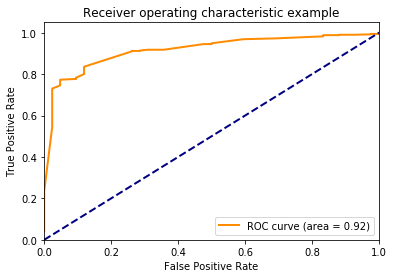

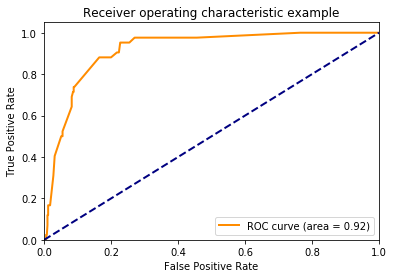

In [426]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_transformed[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area for 0
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_transformed.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Compute micro-average ROC curve and ROC area for 1
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Predict on test data to submission

In [428]:
X_submission = np.array([b_test.mean_time_diff, b_test.total_bids_count,
                         b_test.total_auctions_count]).T
print('X_submission.shape = {}'.format(X_submission.shape))

X_submission.shape = (3875, 3)


In [429]:
submission_prediction = RF_classifier.predict_proba(X_submission)[:,1]
print(submission_prediction)

[ 0.00280366  0.00280366  0.08532486 ...,  0.14690207  0.00280366
  0.06054781]


In [430]:
b_test['prediction'] = submission_prediction
b_test.head()

,bidder_id,mean_time_diff,total_bids_count,total_auctions_count,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,444750.00000,4,3,0.002804
1,a921612b85a1494456e74c09393ccb65ylp4y,722019.50000,3,2,0.002804
2,6b601e72a4d264dab9ace9d7b229b47479v6i,345.62500,17,14,0.085325
3,eaf0ed0afc9689779417274b4791726cn5udi,9890.55102,148,90,0.042377
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,5678.22727,23,20,0.002536


In [431]:
b_test_RF = pd.read_csv('data/SubmissionRF.csv')
b_test_RF.head()

,bidder_id,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,0.002804
1,a921612b85a1494456e74c09393ccb65ylp4y,0.002804
2,6b601e72a4d264dab9ace9d7b229b47479v6i,0.085325
3,eaf0ed0afc9689779417274b4791726cn5udi,0.042377
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,0.002536


In [289]:
for bidder in b_test_RF.bidder_id:
    if (bidder in list(b_test.bidder_id)):
        #print(bidder)
        #print(np.array(b_test[b_test.bidder_id==bidder].prediction)[0])
        b_test_RF.loc[b_test_RF[b_test_RF.bidder_id == bidder].index,
                      'prediction'] = np.array(b_test[b_test.bidder_id==bidder].prediction)[0]

In [291]:
b_test_RF.to_csv('data/SubmissionRF.csv', sep=',', header=True, index=False)

# XGBoost

### Split data

In [185]:
from sklearn.model_selection import train_test_split

X = np.array([b_train.mean_time_diff, b_train.total_bids_count,
              b_train.total_auctions_count]).T
y = np.array(b_train.outcome)
print('X.shape = {}\ny.shape = {}'.format(X.shape, y.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42)

X.shape = (2013, 3)
y.shape = (2013,)


### Train model

In [186]:
__author__ = 'Markiian'
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#parameters of boosting
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 
         'objective': 'binary:logistic',
         'nthread': 4, 'eval_metric': 'auc'}

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.871322	train-auc:0.865817
[1]	eval-auc:0.879813	train-auc:0.886111
[2]	eval-auc:0.89534	train-auc:0.900631
[3]	eval-auc:0.903016	train-auc:0.92157
[4]	eval-auc:0.910249	train-auc:0.926373
[5]	eval-auc:0.904028	train-auc:0.93062
[6]	eval-auc:0.904103	train-auc:0.93368
[7]	eval-auc:0.900301	train-auc:0.940894
[8]	eval-auc:0.900844	train-auc:0.941451
[9]	eval-auc:0.894402	train-auc:0.945272


### Predict on test data to submission

In [188]:
submission_data = xgb.DMatrix(X_submission)
submission_prediction = bst.predict(submission_data)
print(np.round(submission_prediction))
print(submission_prediction)

[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.00057154  0.00057154  0.03677481 ...,  0.05381217  0.00057154
  0.05600484]


### Save into submission file

In [200]:
X_submission = np.array([b_test.mean_time_diff, b_test.total_bids_count,
                         b_test.total_auctions_count]).T
print('X_submission.shape = {}'.format(X_submission.shape))

X_submission.shape = (4700, 3)


In [201]:
b_test['prediction'] = submission_prediction #np.round(submission_prediction)
b_test.head()

,bidder_id,mean_time_diff,total_bids_count,total_auctions_count,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,444750.00000,4,3,0.000572
1,a921612b85a1494456e74c09393ccb65ylp4y,722019.50000,3,2,0.000572
2,6b601e72a4d264dab9ace9d7b229b47479v6i,345.62500,17,14,0.036775
3,eaf0ed0afc9689779417274b4791726cn5udi,9890.55102,148,90,0.021539
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,5678.22727,23,20,0.004564


In [194]:
b_test[['bidder_id','prediction']].to_csv('data/SubmissionXGBoost.csv', sep=',', header=True, index=False)

In [202]:
b_test[['bidder_id','prediction']].to_csv('data/SubmissionRF.csv', sep=',', header=True, index=False)